# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFlite_Version  = "2000"   
TFlite_MainType = "dig-class11"
TFlite_Size     = "s2"
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 250                        # x2 !!!

##########################################################################

## 2024-03-30: Code adapted to TF 2.16 ###################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='03_data_resize_all-use_for_training'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1290, 32, 20, 3)
(1290, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
inputs = tf.keras.Input(shape=(32, 20, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs3)
inputs5 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(256,activation="relu")(inputs9)
output = tf.keras.layers.Dense(11, activation='softmax')(inputs10)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()

#model = Sequential()
#model.add(BatchNormalization(input_shape=(32,20,3)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(256,activation="relu"))
#model.add(Dense(11, activation = "softmax"))

#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

#model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 20, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 20, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 10, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 5, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,023 (343.84 KB)

 Trainable params: 88,017 (343.82 KB)

 Non-trainable params: 6 (24.00 B)

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.2
Rotation_Angle = 5
ZoomRange = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/250


C:\Users\Muell\anaconda3\envs\py311-tf218\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2656 - loss: 2.2898
Epoch 2/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3842 - loss: 1.8802 
Epoch 3/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6197 - loss: 1.1927 
Epoch 4/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6952 - loss: 0.9377  
Epoch 5/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7679 - loss: 0.7480 
Epoch 6/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8068 - loss: 0.6139  
Epoch 7/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8373 - loss: 0.4910 
Epoch 8/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8588 - loss: 0.4928 
Epoch 9/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8543 - loss: 0.4535 
Epoch 10/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8664 - loss: 0.4448 
Epoch 11/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8842 - loss: 0.3532 
Epoch 12/250
323/323 ━━━━━━━━━━━━━━━━━━━━

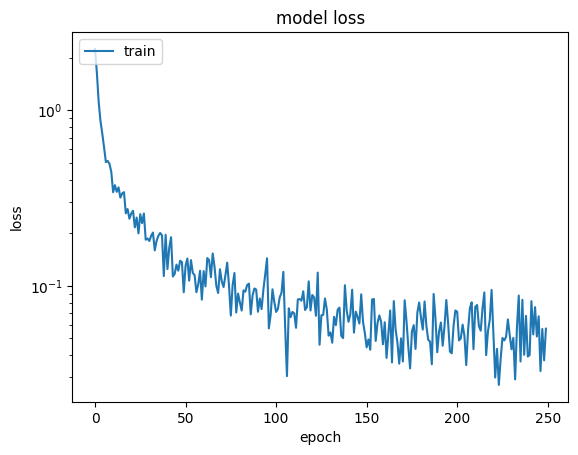

Epoch 1/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9930 - loss: 0.0456     
Epoch 2/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9876 - loss: 0.0507 
Epoch 3/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9895 - loss: 0.0829     
Epoch 4/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9840 - loss: 0.0451     
Epoch 5/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9919 - loss: 0.0440     
Epoch 6/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9944 - loss: 0.0294     
Epoch 7/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9917 - loss: 0.0243     
Epoch 8/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9822 - loss: 0.0790
Epoch 9/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9814 - loss: 0.0684 
Epoch 10/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9892 - loss: 0.0438     
Epoch 11/250
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9894 - loss: 0.0270 
Epo

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

if (Training_Percentage > 0):
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    history = model.fit(train_iterator, epochs = Epoch_Anz)



### Learing result
 
* Visualization of the training and validation results

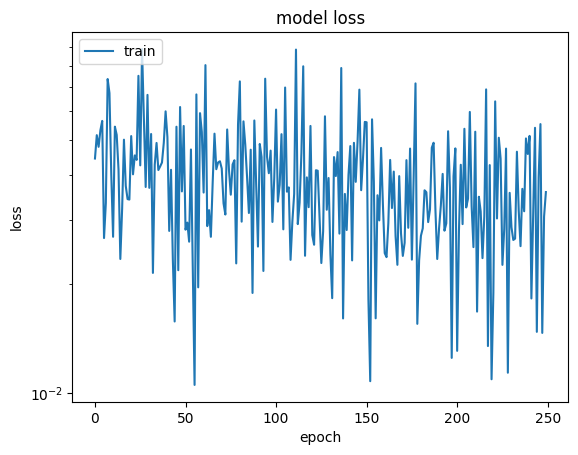

In [6]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


03_data_resize_all-use_for_training\0.0_ROI0_20211125-030625.jpg 0 9


03_data_resize_all-use_for_training\0.0_ROI0_20211125-034125.jpg 0 9


03_data_resize_all-use_for_training\5_5_ROI4_20210418-173416.jpg 5 -1


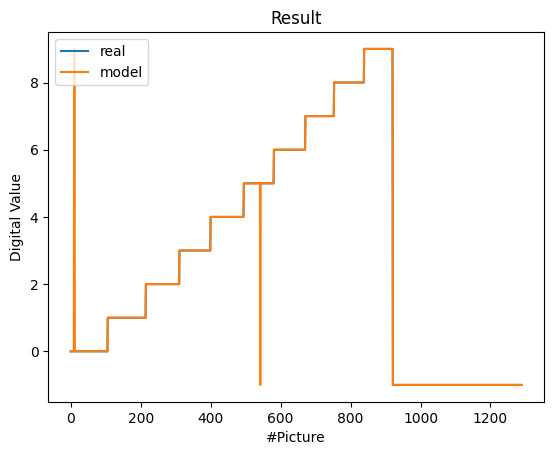

In [13]:
Input_dir='03_data_resize_all-use_for_training'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img, verbose=0), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
#model.export("test", "tf_saved_model")  # replace tf.saved_model.save with this line

In [15]:
FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size + ".tflite"

converter = tf.lite.TFLiteConverter.from_saved_model("test")
tflite_model = converter.convert()
open(FileName, "wb").write(tflite_model)
print(FileName)
Path(FileName).stat().st_size

dig-class11_2000_s2.tflite


356636

In [16]:
FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size + "_q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_saved_model("test")
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
converter2._experimental_disable_per_channel_quantization_for_dense_layers = True

tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

dig-class11_2000_s2_q.tflite


97192

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.